In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL do site IPEADATA
url = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'

# Faz uma requisição GET ao site e captura a resposta
response = requests.get(url)

# Verifica se a requisição foi bem sucedida
if response.status_code == 200:
    # Cria um objeto BeautifulSoup para analisar o HTML
    soup = BeautifulSoup(response.text, 'html.parser')

    # Procura pela tabela no HTML analisado (o id ou classe pode variar)
    # Você precisaria inspecionar o HTML para obter o seletor correto
    table = soup.find('table', {'id': 'grd_DXMainTable'})

    # Usa o pandas para ler a tabela HTML diretamente para um DataFrame
    df = pd.read_html(str(table),skiprows=0)[0]

    df.columns = df.iloc[0]
    df = df.drop(0)

    # Mostra as primeiras linhas do DataFrame
    df.head()
else:
    print('Falha ao acessar a página: Status Code', response.status_code)


In [ ]:
df

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

# Função para atualizar o DataFrame com novos dados
def update_dataframe(df, new_data):
    # Converte a coluna 'Data' para datetime
    df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
    new_data['Data'] = pd.to_datetime(new_data['Data'], dayfirst=True)

    # Encontra a data mais recente no DataFrame existente
    last_date = df['Data'].max()

    # Filtra as novas linhas que são mais recentes do que a última data
    new_rows = new_data[new_data['Data'] > last_date]

    # Concatena os novos dados com o DataFrame existente se houver novas linhas
    if not new_rows.empty:
        updated_df = pd.concat([df, new_rows], ignore_index=True)
    else:
        updated_df = df

    return updated_df

# URL do site IPEADATA
url = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'

# Faz uma requisição GET ao site e captura a resposta
response = requests.get(url)

# Verifica se a requisição foi bem sucedida
if response.status_code == 200:
    # Cria um objeto BeautifulSoup para analisar o HTML
    soup = BeautifulSoup(response.text, 'html.parser')
    # Procura pela tabela no HTML analisado
    table = soup.find('table', {'id': 'grd_DXMainTable'})
    # Usa o pandas para ler a tabela HTML diretamente para um DataFrame
    new_df = pd.read_html(str(table), header=0)[0]

    # Verifica se o arquivo do DataFrame existe e carrega, ou cria um novo DataFrame se não existir
    path = '/home/matheus/Área de Trabalho/dtat-brent-price/data/ipea.csv'
    try:
        existing_df = pd.read_csv(path)
    except FileNotFoundError:
        existing_df = new_df  # Se o arquivo não existir, considere os dados atuais como o DataFrame existente

    # Atualiza o DataFrame existente com novos dados (carga incremental)
    updated_df = update_dataframe(existing_df, new_df)

    updated_df['Preço - petróleo bruto - Brent (FOB)'] = updated_df['Preço - petróleo bruto - Brent (FOB)']/100

    # Salva o DataFrame atualizado para o arquivo
    updated_df.to_csv(path, index=False)

    # Mostra as primeiras linhas do DataFrame atualizado
    updated_df.head()
else:
    print('Falha ao acessar a página: Status Code', response.status_code)

In [ ]:
updated_df

In [ ]:
updated_df.info()

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Definir o dispositivo para a GPU se disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carregar o DataFrame
df = pd.read_csv('/content/ipea.csv')

# Converter a coluna de data para datetime e depois para timestamp Unix
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df = df.sort_values(by='Data',ascending=True)
df['Timestamp'] = df['Data'].values.astype('int64') // 10**9

# Escalar a coluna de preços, já que os modelos de DL geralmente funcionam melhor com dados normalizados
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Preço - petróleo bruto - Brent (FOB)'] = scaler.fit_transform(df['Preço - petróleo bruto - Brent (FOB)'].values.reshape(-1, 1)).astype('float32')

# Preparar dados para o PyTorch
X = df['Timestamp'].values.astype('float32')  # A entrada do modelo será o timestamp
y = df['Preço - petróleo bruto - Brent (FOB)'].values.astype('float32')  # A saída do modelo serão os preços

# Dividir o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Converter os dados para Tensor
X_train_tensor = torch.tensor(X_train).view(-1, 1, 1)
y_train_tensor = torch.tensor(y_train).view(-1, 1, 1)
X_test_tensor = torch.tensor(X_test).view(-1, 1, 1)
y_test_tensor = torch.tensor(y_test).view(-1, 1, 1)

# Mover para o dispositivo apropriado
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Definir o modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=200, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size ,num_layers=3)

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Instanciar o modelo
model = LSTMModel().to(device)

# Definir a função de perda e o otimizador
loss_function = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.0001)

# Treinar o modelo
epochs = 10
for i in range(epochs):
    for seq, labels in zip(X_train_tensor, y_train_tensor):
        optimizer.zero_grad()

        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

        print(f'Epoch {i} loss: {single_loss.item()}')

model.eval()
with torch.no_grad():
    preds = []
    for i in range(len(X_test)):
        seq = X_test_tensor[i : i + 1]
        preds.append(model(seq).cpu().numpy()[0])

# Inverter a escala dos preços para a escala original
actual_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# Plotar
plt.figure(figsize=(15,5))
plt.plot(df.index[-len(actual_predictions):], actual_predictions, label='Predicted')
plt.plot(df.index[-len(actual_predictions):], scaler.inverse_transform(y_test.reshape(-1,1)), label='Actual')
plt.legend()
plt.show()

In [ ]:
# Prever usando o conjunto de teste
predictions = []
with torch.no_grad():
    for i in range(len(X_test)):
        seq = X_test_tensor[i : i+1]
        predictions.append(model(seq).item())
predictions = np.array(predictions).reshape(-1, 1)
predictions = scaler.inverse_transform(predictions) # Reverter escala dos dados de previsão

# Reverter escala dos dados reais de teste
actual = scaler.inverse_transform(y_test.reshape(-1,1))

# Plotagem do gráfico
plt.figure(figsize=(15,6))
plt.plot(df['Data'].iloc[-len(predictions):], actual, label='Actual Data')
plt.plot(df['Data'].iloc[-len(predictions):], predictions, label='Predicted Data')
plt.legend()
plt.title('Preços reais vs previsões')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.grid(True)
plt.show()

Mean Squared Error: 2.836992512397856
Mean Absolute Error: 1.1848350437487067


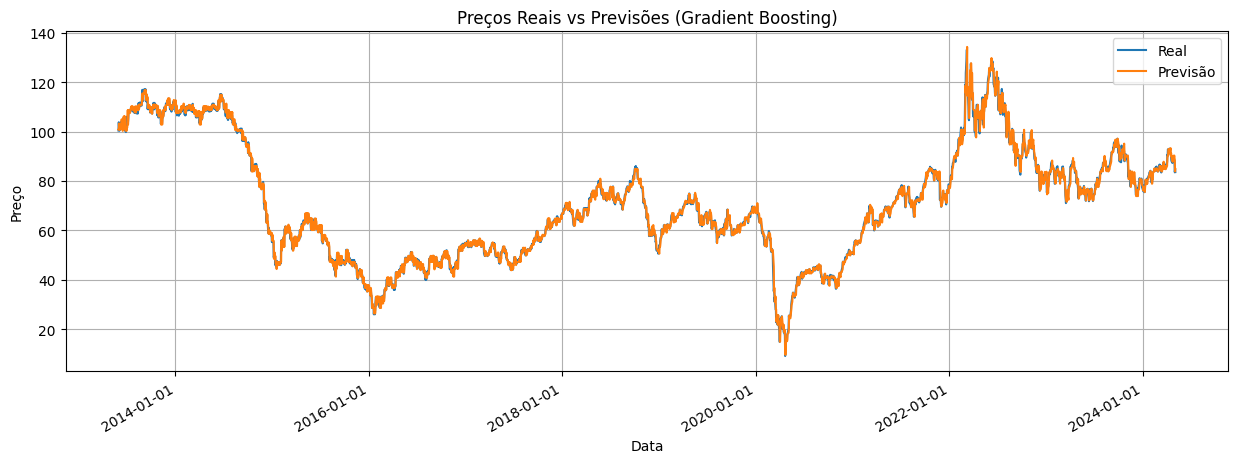

In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Carregar o DataFrame
df = pd.read_csv('/home/matheus/Área de Trabalho/dtat-brent-price/data/ipea.csv')
df['Data'] = pd.to_datetime(df['Data'])
df = df.sort_values(by='Data', ascending=True).reset_index(drop=True)
#df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
#df['Preço'] = df['Preço'].astype(float)  # Certifique-se de que os preços são float

# É uma boa prática criar recursos de atraso (lag features) para séries temporais
# Vamos criar alguns para nosso modelo
for lag in range(1, 2):  # Criar atrasos de 1 dia até 3 dias
    df[f'Preço_lag_{lag}'] = df['Preço - petróleo bruto - Brent (FOB)'].shift(lag)

# Removemos quaisquer linhas com valores NaN que foram criados ao fazer o shift
df = df.dropna()

# Preparando os dados para treinamento
X = df[['Preço_lag_1']].values  # Inputs são os preços atrasados
y = df['Preço - petróleo bruto - Brent (FOB)'].values  # Output é o preço atual

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)

# Criar e treinar o modelo de Gradient Boosting
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, loss='squared_error')
model.fit(X_train, y_train)

# Fazer previsões
predictions = model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# Opcional: Plotando resultados reais vs previstos. Tem que ter matplotlib instalado.
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 5))
plt.plot(df['Data'].iloc[-len(y_test):], y_test, label='Real')
plt.plot(df['Data'].iloc[-len(predictions):], predictions, label='Previsão')
# Melhorar a formatação do eixo x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formatar as datas como 'Ano-Mês-Dia'
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())             # Escolher automaticamente a localização das datas
# Melhorar a legibilidade girando as datas e ajustando o espaçamento
plt.gcf().autofmt_xdate()  # Gira as datas para evitar sobreposição
plt.legend()
plt.xlabel('Data')
plt.ylabel('Preço')
plt.grid(True)
plt.title('Preços Reais vs Previsões (Gradient Boosting)')
plt.show()

In [2]:
df

,Data,Preço - petróleo bruto - Brent (FOB),Preço_lag_1
1,1987-05-21,18.45,18.63
2,1987-05-22,18.55,18.45
3,1987-05-25,18.60,18.55
4,1987-05-26,18.63,18.60
5,1987-05-27,18.60,18.63
...,...,...,...
11159,2024-04-29,88.44,89.95
11160,2024-04-30,88.23,88.44
11161,2024-05-01,83.55,88.23
11162,2024-05-02,84.81,83.55


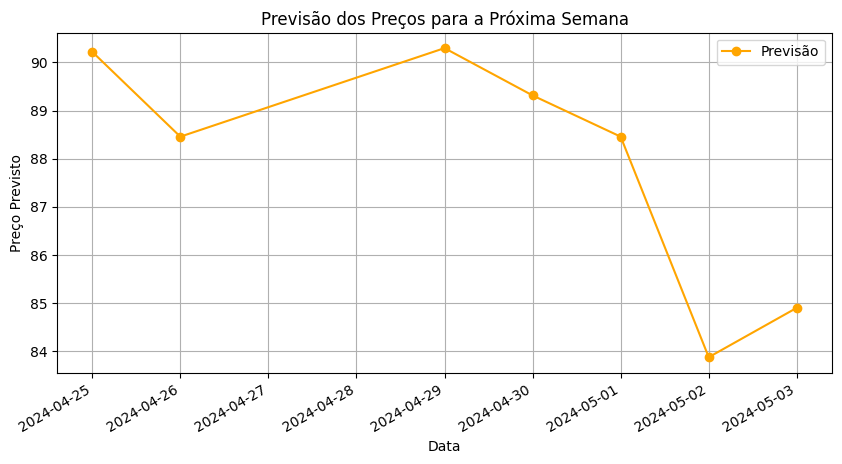

In [3]:
predictions_next_week = predictions[-7:]  # Ajustar o número conforme necessário
df_next_week_dates = df['Data'].iloc[-len(y_test):][-7:]  # Ajustar o número conforme necessário

# Plotar os resultados
plt.figure(figsize=(10, 5))
# Certifique-se de reverter os dados para que as datas sejam plotadas em ordem cronológica
plt.plot(df_next_week_dates[::-1], predictions_next_week[::-1], label='Previsão', color='orange', marker='o')

# Formatar o eixo x para apresentar as datas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()  # Auto formatar as datas para evitar sobreposição

plt.title('Previsão dos Preços para a Próxima Semana')
plt.xlabel('Data')
plt.ylabel('Preço Previsto')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
len(predictions)

In [ ]:
X_train

Mean Squared Error: 2.8078026649142167
Mean Absolute Error: 1.1816881103607033
2024-05-04 00:00:00: 84.74
2024-05-05 00:00:00: 83.86
2024-05-06 00:00:00: 84.74
2024-05-07 00:00:00: 83.86
2024-05-08 00:00:00: 84.74
2024-05-09 00:00:00: 83.86
2024-05-10 00:00:00: 84.74


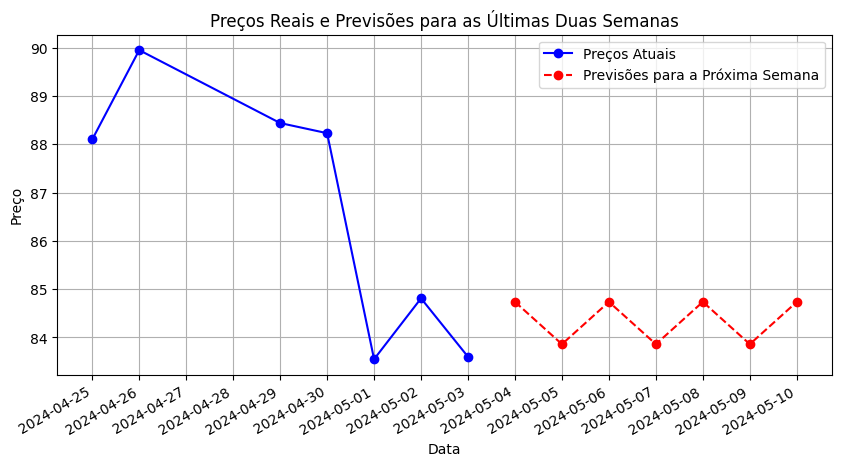

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator


# Carregar o DataFrame
df = pd.read_csv('/home/matheus/Área de Trabalho/dtat-brent-price/data/ipea.csv')
df['Data'] = pd.to_datetime(df['Data'])
df = df.sort_values(by='Data', ascending=True).reset_index(drop=True)
#df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
#df['Preço'] = df['Preço'].astype(float)  # Certifique-se de que os preços são float

# É uma boa prática criar recursos de atraso (lag features) para séries temporais
# Vamos criar alguns para nosso modelo
# Criar recursos de atraso (lag features)
lags = 7
for lag in range(1, lags + 1):
    df[f'Preço_lag_{lag}'] = df['Preço - petróleo bruto - Brent (FOB)'].shift(lag)

# Removemos quaisquer linhas com valores NaN que foram criados ao fazer o shift
df = df.dropna()

# Preparando os dados para treinamento
X = df[['Preço_lag_1','Preço_lag_2']].values  # Inputs são os preços atrasados
y = df['Preço - petróleo bruto - Brent (FOB)'].values  # Output é o preço atual

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Criar e treinar o modelo de Gradient Boosting
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, loss='squared_error')
model.fit(X_train, y_train)

# Fazer previsões
predictions = model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
# Fazer previsões para a próxima semana usando os últimos dados conhecidos
last_known_data = X[-1].reshape(1, -1)
next_week_predictions = []
for _ in range(7):  # para cada dia da próxima semana
    next_day_pred = model.predict(last_known_data)[0]
    next_week_predictions.append(next_day_pred)
    last_known_data = np.roll(last_known_data, -1)
    last_known_data[0, -1] = next_day_pred

# As datas correspondentes à próxima semana
next_week_dates = pd.date_range(df['Data'].iloc[-1], periods=8)[1:]

# Selecionar os dados da semana atual (últimos 7 dias do dataset)
current_week_dates = df['Data'].iloc[-7:]
current_week_prices = df['Preço - petróleo bruto - Brent (FOB)'].iloc[-7:]

for week, pred in zip(next_week_dates, next_week_predictions):
    print(f'{week}: {pred:.2f}')

# Plotar os preços reais da semana atual e as previsões para a próxima semana
plt.figure(figsize=(10, 5))
plt.plot(current_week_dates, current_week_prices, 'bo-', label='Preços Atuais')
plt.plot(next_week_dates, next_week_predictions, 'r--o', label='Previsões para a Próxima Semana')

# Formatar o eixo x para exibir datas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()  # Ajustar formato das datas para evitar sobreposição

plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Preços Reais e Previsões para as Últimas Duas Semanas')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
df

,Data,Preço - petróleo bruto - Brent (FOB),Preço_lag_1,Preço_lag_2,Preço_lag_3,Preço_lag_4,Preço_lag_5,Preço_lag_6,Preço_lag_7
7,1987-05-29,18.58,18.60,18.60,18.63,18.60,18.55,18.45,18.63
8,1987-06-01,18.65,18.58,18.60,18.60,18.63,18.60,18.55,18.45
9,1987-06-02,18.68,18.65,18.58,18.60,18.60,18.63,18.60,18.55
10,1987-06-03,18.75,18.68,18.65,18.58,18.60,18.60,18.63,18.60
11,1987-06-04,18.78,18.75,18.68,18.65,18.58,18.60,18.60,18.63
...,...,...,...,...,...,...,...,...,...
11159,2024-04-29,88.44,89.95,88.10,89.02,88.29,87.30,87.96,88.34
11160,2024-04-30,88.23,88.44,89.95,88.10,89.02,88.29,87.30,87.96
11161,2024-05-01,83.55,88.23,88.44,89.95,88.10,89.02,88.29,87.30
11162,2024-05-02,84.81,83.55,88.23,88.44,89.95,88.10,89.02,88.29
